# RQ3: Which factors most influence a game’s sale?(Regression model)

## 1. Prepare the environment

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



## 2. Load the dataset

In [192]:
df = pd.read_csv('final_dataset.csv', parse_dates=['released'])
df['Year'] = df['released'].dt.year

## 3. Create the four Regression models

### 3.1 Baseline model

In [195]:
# baseline columns, target
baseline_feats = ['Genre','Platform','Publisher']
target = 'Global_Sales(MM)'

# One‑hot encode
X_base = pd.get_dummies(df_base[baseline_feats], drop_first=True)
y_base = df_base[target].values

print("Baseline X shape:", X_base.shape)


Baseline X shape: (4384, 230)


In [196]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)


#### 3.1.1 LinearRegression

In [198]:
lr_base = LinearRegression()
lr_base.fit(Xb_train, yb_train)
yb_pred = lr_base.predict(Xb_test)

print("Baseline Linear Regression")
print("  RMSE:", np.sqrt(mean_squared_error(yb_test, yb_pred)))
print("  R²  :", r2_score(yb_test, yb_pred))


Baseline Linear Regression
  RMSE: 5955793958490.3545
  R²  : -1.2492371631462305e+25


#### 3.1.2 Random Forest Regressor

In [200]:
rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_base.fit(Xb_train, yb_train)
yb_rf = rf_base.predict(Xb_test)

print("Baseline Random Forest Regressor")
print("  RMSE:", np.sqrt(mean_squared_error(yb_test, yb_rf)))
print("  R²  :", r2_score(yb_test, yb_rf))


Baseline Random Forest Regressor
  RMSE: 1.7003526371241917
  R²  : -0.018224550920254323


### 3.2 Full features model

In [202]:
full_features = [
    'Year','metacritic','rating','ratings_count',
    'playtime','Genre','Platform',
    'Publisher','Platform_Group'
]

df_full = df.dropna(subset=[target])
X_full = pd.get_dummies(df_full[full_features], drop_first=True)
y_full = df_full[target].values

print("Full X shape:", X_full.shape)


Full X shape: (4384, 241)


In [203]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)


#### 3.2.1 Ridge Regression

In [205]:
ridge = Ridge(alpha=1.0)
ridge.fit(Xf_train, yf_train)
yf_ridge = ridge.predict(Xf_test)

print("Full Ridge Regression")
print("  RMSE:", np.sqrt(mean_squared_error(yf_test, yf_ridge)))
print("  R²  :", r2_score(yf_test, yf_ridge))


Full Ridge Regression
  RMSE: 1.5681962107529996
  R²  : 0.1339033356641517


#### 3.2.2 Random Forest Regressor

In [207]:
rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_full.fit(Xf_train, yf_train)
yf_rf = rf_full.predict(Xf_test)

print("Full Random Forest Regressor")
print("  RMSE:", np.sqrt(mean_squared_error(yf_test, yf_rf)))
print("  R²  :", r2_score(yf_test, yf_rf))


Full Random Forest Regressor
  RMSE: 1.2708609293171171
  R²  : 0.43119733558288065


### 3.3 Results

In [209]:
results = pd.DataFrame({
    'Model': [
        'Baseline Linear Regression','Baseline Random Forest Regressor',
        'Full Ridge Regression','Full Random Forest Regressor'
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(yb_test, yb_pred)),
        np.sqrt(mean_squared_error(yb_test, yb_rf)),
        np.sqrt(mean_squared_error(yf_test, yf_ridge)),
        np.sqrt(mean_squared_error(yf_test, yf_rf))
    ],
    'R^2': [
        r2_score(yb_test, yb_pred),
        r2_score(yb_test, yb_rf),
        r2_score(yf_test, yf_ridge),
        r2_score(yf_test, yf_rf)
    ]
})
display(results)


,Model,RMSE,R^2
0,Baseline Linear Regression,5.955794e+12,-1.249237e+25
1,Baseline Random Forest Regressor,1.700353e+00,-1.822455e-02
2,Full Ridge Regression,1.568196e+00,1.339033e-01
3,Full Random Forest Regressor,1.270861e+00,4.311973e-01


### 3.4 Test the Full Random Forest Regressor model's results

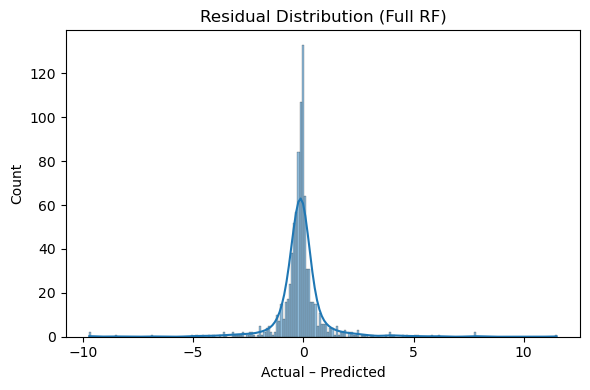

In [211]:
res = yf_test - yf_rf
plt.figure(figsize=(6,4))
sns.histplot(res, kde=True)
plt.title("Residual Distribution (Full RF)")
plt.xlabel("Actual – Predicted")
plt.tight_layout()
plt.show()


### 3.5  Top 15 influential features

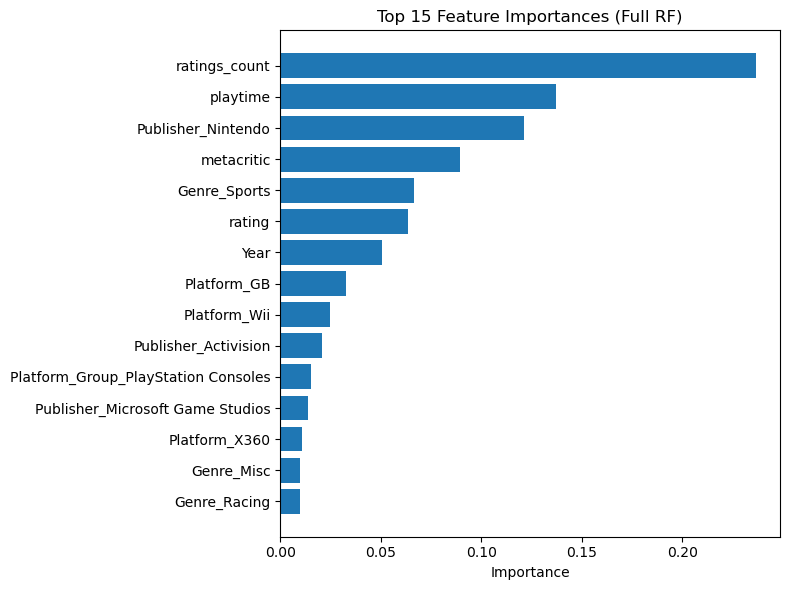

In [213]:
importances = rf_full.feature_importances_
idx = np.argsort(importances)[::-1][:15]  # top 15
plt.figure(figsize=(8,6))
plt.barh(X_full.columns[idx][::-1], importances[idx][::-1])
plt.title("Top 15 Feature Importances (Full RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 4. Regional Markets

### 4.1 Rebuild the Random Forest Regressor model for regional markets

In [216]:
def train_rf_for_target(df, features, target, test_size=0.2, random_state=42):

    df2 = df
    X = pd.get_dummies(df2[features], drop_first=True)
    y = df2[target].values

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Train
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf.fit(X_train, y_train)

    return rf, X_train.columns, (X_test, y_test)


In [217]:

rf_global, feat_names, (Xg_test, yg_test) = train_rf_for_target(df, full_feats, 'Global_Sales(MM)')
rf_EU,     _,         (Xeu_test, yeu_test) = train_rf_for_target(df, full_feats, 'EU_Sales(MM)')
rf_NA,   _,         (Xna_test, yna_test)   = train_rf_for_target(df, full_feats, 'NA_Sales(MM)')
rf_JP,   _,         (Xjp_test, yjp_test)   = train_rf_for_target(df, full_feats, 'JP_Sales(MM)')

### 4.2 Top 10 influential features in global and regional markets 

In [219]:
def get_top_importances(rf_model, feature_names, n=10):
    imp = pd.Series(rf_model.feature_importances_, index=feature_names)
    return imp.nlargest(n)

top_global = get_top_importances(rf_global, feat_names, n=10)
top_eu   = get_top_importances(rf_EU,     feat_names, n=10)
top_na = get_top_importances(rf_NA,   feat_names, n=10)
top_jp = get_top_importances(rf_JP,   feat_names, n=10)

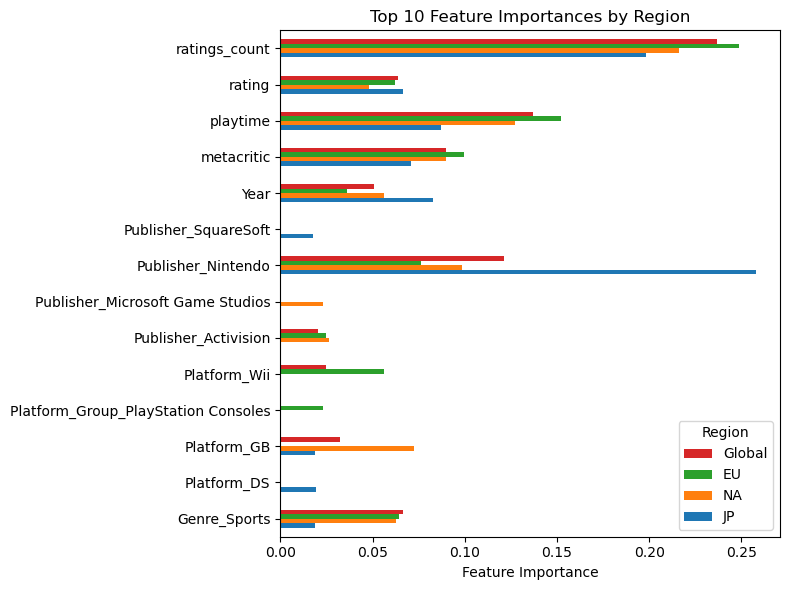

In [220]:
region_colors = {
    'Global': '#d62728',  # red
    'EU': '#2ca02c',      # green
    'NA': '#ff7f0e',      # orange
    'JP': '#1f77b4'       # blue
}

comp = pd.DataFrame({
    'Global': top_global,
    'EU': top_eu,
    'NA': top_na,
    'JP': top_jp
}).fillna(0)

cols = ['Global', 'EU', 'NA', 'JP']

plot_df = comp[cols[::-1]]

bar_colors = [region_colors[col] for col in plot_df.columns]

ax = plot_df.plot.barh(figsize=(8, 6), legend=False, color=bar_colors)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Region")

ax.set_title("Top 10 Feature Importances by Region")
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()


#### 4.2.1 Global vs Europe

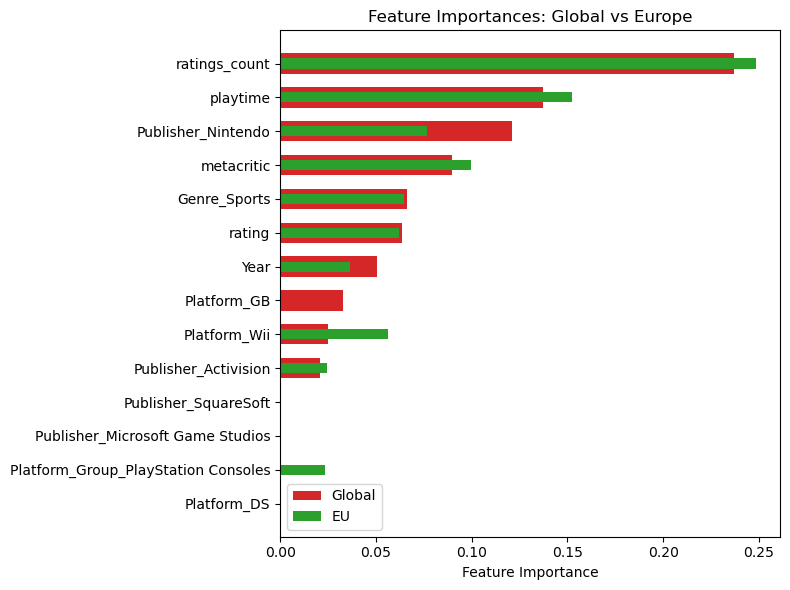

In [222]:
plot_df = comp[['Global', 'EU']].sort_values('Global', ascending=True)

bar_width = 0.6
narrow_bar_width = 0.3
y_pos = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(y_pos, plot_df['Global'], height=bar_width, label='Global',
        color=region_colors['Global'])

ax.barh(y_pos, plot_df['EU'], height=narrow_bar_width, label='EU',
        color=region_colors['EU'])

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df.index)

ax.set_title("Feature Importances: Global vs Europe")
ax.set_xlabel("Feature Importance")
ax.legend()
plt.tight_layout()
plt.show()



#### 4.2.2 Global vs North America

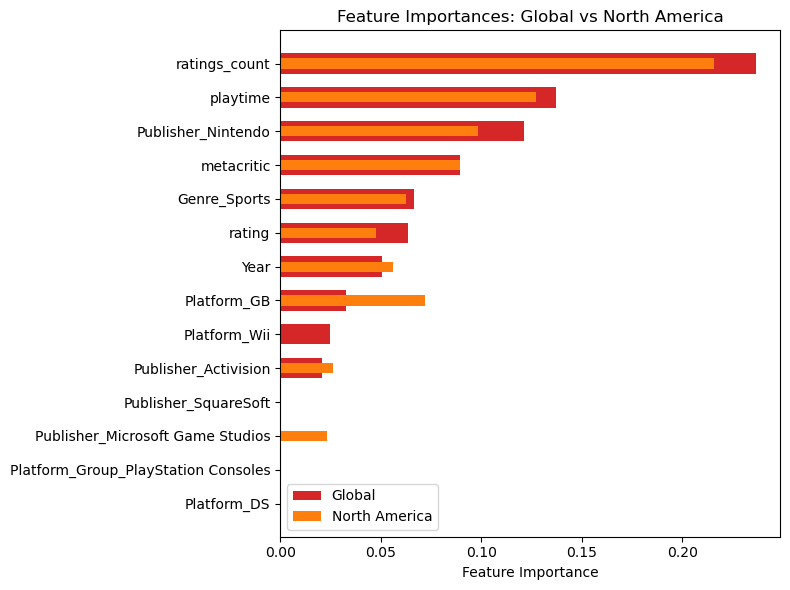

In [224]:
plot_df = comp[['Global', 'NA']].sort_values('Global', ascending=True)

bar_width = 0.6
narrow_bar_width = 0.3
y_pos = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(y_pos, plot_df['Global'], height=bar_width, label='Global',
        color=region_colors['Global'])

ax.barh(y_pos, plot_df['NA'], height=narrow_bar_width, label='North America',
        color=region_colors['NA'])

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df.index)

ax.set_title("Feature Importances: Global vs North America")
ax.set_xlabel("Feature Importance")
ax.legend()
plt.tight_layout()
plt.show()



#### 4.2.3 Global vs Japan

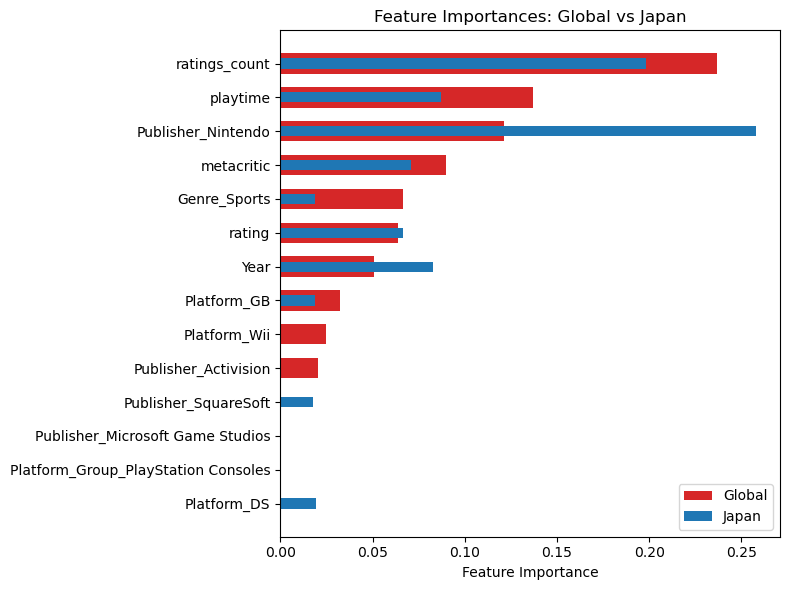

In [226]:
plot_df = comp[['Global', 'JP']].sort_values('Global', ascending=True)

bar_width = 0.6
narrow_bar_width = 0.3
y_pos = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(y_pos, plot_df['Global'], height=bar_width, label='Global',
        color=region_colors['Global'])

ax.barh(y_pos, plot_df['JP'], height=narrow_bar_width, label='Japan',
        color=region_colors['JP'])

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df.index)

ax.set_title("Feature Importances: Global vs Japan")
ax.set_xlabel("Feature Importance")
ax.legend()
plt.tight_layout()
plt.show()



## 5. Additional Testing

### 5.1 Actual vs Predicted

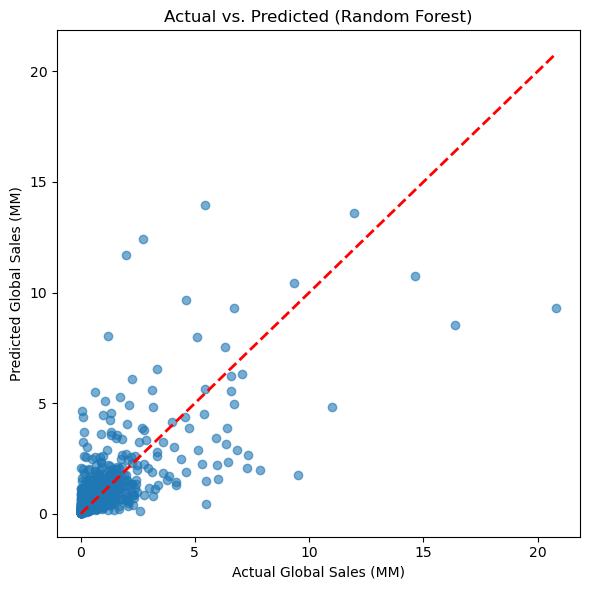

In [229]:
y_pred = rf_full.predict(Xf_test)

plt.figure(figsize=(6,6))
plt.scatter(yf_test, y_pred, alpha=0.6)
plt.plot([yf_test.min(), yf_test.max()],
         [yf_test.min(), yf_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Global Sales (MM)")
plt.ylabel("Predicted Global Sales (MM)")
plt.title("Actual vs. Predicted (Random Forest)")
plt.tight_layout()
plt.show()


### 5.2 Actual values (Actual vs Predicted)

In [231]:
# recover the mapping
test_idx = Xf_test.index
df_test = df_full.iloc[test_idx].copy()
df_test['Predicted'] = y_pred
df_test['Actual']    = yf_test

display(df_test[['name','Year','Genre','Platform','Actual','Predicted']]
        .sort_values('Actual', ascending=False)
        .head(10))


,name,Year,Genre,Platform,Actual,Predicted
157,Grand Theft Auto: San Andreas,2004,Action,PS2,20.81,9.3160
2585,Grand Theft Auto V,2013,Action,X360,16.38,8.5572
2755,Call of Duty: Black Ops,2010,Shooter,X360,14.64,10.7514
2586,Grand Theft Auto V,2013,Action,PS4,11.98,13.5955
1010,Grand Theft Auto IV,2008,Action,X360,11.02,4.8532
3927,Just Dance 2,2010,Misc,Wii,9.52,1.7624
1114,Call of Duty 4: Modern Warfare,2007,Shooter,X360,9.32,10.4211
14,FINAL FANTASY VIII,1999,Role-Playing,PS,7.86,1.9785
2884,Battlefield 3,2011,Shooter,X360,7.34,2.6556
2233,Just Dance,2009,Misc,Wii,7.27,2.0818


### 5.3 Aggregated Actual vs Predicted

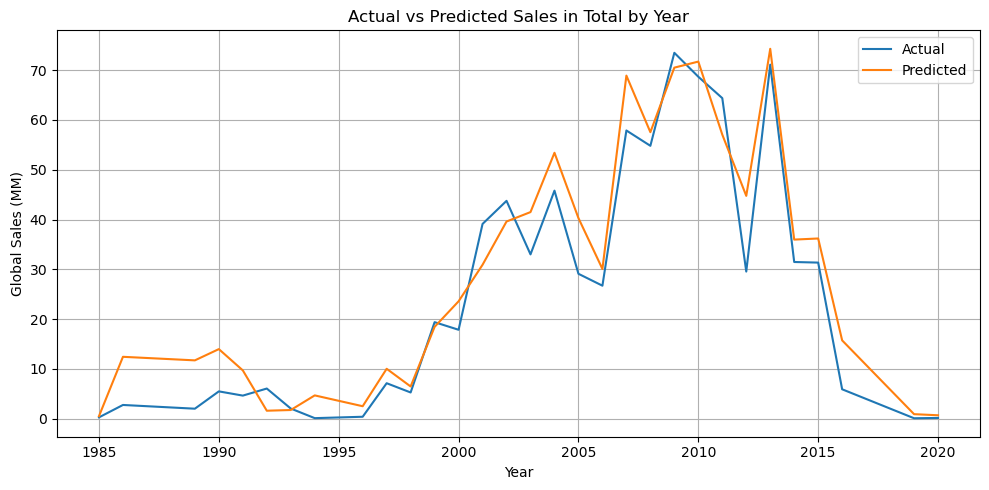

In [233]:
aggregate = df_test.groupby('Year')[['Actual','Predicted']].sum().dropna()

aggregate.plot(figsize=(10,5))
plt.ylabel("Global Sales (MM)")
plt.title("Actual vs Predicted Sales in Total by Year")
plt.grid(True)
plt.tight_layout()
plt.show()
